Mount to Google Drive directory (not necessary if on local machine)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/pied-paper

/content/drive/My Drive/pied-paper


Change PyTorch and Torchtext version (using legacy features)

In [ ]:
!pip install --upgrade torch==1.8.0
!pip install --upgrade torchtext==0.9.0
# !pip show torch
# !pip show torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 735.5 MB 13 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.1 MB 6.7 MB/s 
  Attempting uninstall: torchtext
    Found existing installa

Download spacy tokenizer

In [ ]:
!python -m spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 8.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


Data has already been preprocessed; it is in 'preprocessed/'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchtext.legacy.data import Field, TabularDataset, BucketIterator

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load data as train, valid, test data

In [ ]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True, fix_length=200)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path='preprocessed', train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3, vectors="glove.6B.100d")

Build vocabulary and print example words

In [ ]:
examples = train.examples
print("Number of tokens: ", len(examples[0].text))
print("\n")
print("Print first 200 tokens: ",examples[0].text[:200])
print("\n")
print("Print last 10 tokens: ",examples[0].text[-10:])

Number of tokens:  228


Print first 200 tokens:  ['the', 'justice', 'department', 'announced', 'wednesday', 'that', 'it', 'will', 'not', 'prosecute', 'former', 'ferguson', ',', 'mo.', ',', 'police', 'officer', 'darren', 'wilson', 'in', 'the', 'shooting', 'death', 'of', 'an', 'unarmed', 'black', '18-year', '-', 'old', ',', 'while', 'also', 'releasing', 'a', 'report', 'faulting', 'the', 'city', 'and', 'its', 'law', 'enforcement', 'for', 'racial', 'bias', '.', 'in', 'the', 'criminal', 'investigation', ',', 'federal', 'officials', 'concluded', 'wilson', "'s", 'actions', '"', 'do', 'not', 'constitute', 'prosecutable', 'violations', 'under', 'the', 'applicable', 'federal', 'criminal', 'rights', 'statute', '.', '"', 'specifically', ',', 'the', 'doj', 'said', 'there', 'was', '"', 'no', 'evidence', '"', 'to', 'disprove', 'wilson', "'s", 'testimony', 'that', 'he', 'feared', 'for', 'his', 'safety', ',', 'nor', 'was', 'there', 'reliable', 'evidence', 'that', 'michael', 'brown', 'had', 'his', 'han

In [ ]:
vocab = text_field.vocab

In [ ]:

print("Vocabulary size: ", len(vocab))
print("10 most frequent words: ", vocab.freqs.most_common(10))

Vocabulary size:  20997
10 most frequent words:  [('the', 98848), (',', 82312), ('.', 62471), ('to', 45903), ('of', 42833), ('and', 37677), ('a', 37278), ('in', 33756), ('that', 21445), ('is', 17957)]


In [ ]:
print("First 10 words: ", vocab.itos[0:10])
print("First 200 words of text data: ", train.examples[0].text[:200])
print("Index of the first word: ", vocab.stoi[train.examples[0].text[0]])

First 10 words:  ['<unk>', '<pad>', 'the', ',', '.', 'to', 'of', 'and', 'a', 'in']
First 200 words of text data:  ['the', 'justice', 'department', 'announced', 'wednesday', 'that', 'it', 'will', 'not', 'prosecute', 'former', 'ferguson', ',', 'mo.', ',', 'police', 'officer', 'darren', 'wilson', 'in', 'the', 'shooting', 'death', 'of', 'an', 'unarmed', 'black', '18-year', '-', 'old', ',', 'while', 'also', 'releasing', 'a', 'report', 'faulting', 'the', 'city', 'and', 'its', 'law', 'enforcement', 'for', 'racial', 'bias', '.', 'in', 'the', 'criminal', 'investigation', ',', 'federal', 'officials', 'concluded', 'wilson', "'s", 'actions', '"', 'do', 'not', 'constitute', 'prosecutable', 'violations', 'under', 'the', 'applicable', 'federal', 'criminal', 'rights', 'statute', '.', '"', 'specifically', ',', 'the', 'doj', 'said', 'there', 'was', '"', 'no', 'evidence', '"', 'to', 'disprove', 'wilson', "'s", 'testimony', 'that', 'he', 'feared', 'for', 'his', 'safety', ',', 'nor', 'was', 'there', 'relia

MLP

Class definition

In [ ]:
class TextClass(nn.Module):
  def __init__(self):
    super(TextClass, self).__init__()
    self.embed = nn.Embedding(len(vocab), embedding_dim=100)
    self.embed.weight.data.copy_(vocab.vectors)
    self.fc = nn.Linear(in_features=200*100, out_features=2)
  def forward(self, input, lengths=None):
    embed = self.embed(input)

    if lengths is not None:
      lengths = lengths.view(-1).tolist()
      packed_emb = pack_padded_sequence(embed, lengths)

    embed = embed.reshape(-1, 200*100)

    fc = self.fc(embed)
    out = fc

    return out

Data shape, for debugging purposes

In [ ]:
data = next(iter(train_iter))
(x, x_len), y = data.titletext, data.label
print(x.shape)
print(x_len.shape)
print(y.shape)

torch.Size([32, 200])
torch.Size([32])
torch.Size([32])


In [ ]:
print(len(train_iter))
print(len(valid_iter))
print(len(test_iter))

142
36
20


Initialize model, optimizer, and loss criterion

In [ ]:
device = 'cpu'
model = TextClass().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
print(model)

TextClass(
  (embed): Embedding(20997, 100)
  (fc): Linear(in_features=20000, out_features=2, bias=True)
)


Test of embedding layer, for debugging purposes

In [ ]:
embedding = nn.Embedding(len(vocab), 100)
input = torch.LongTensor([[1,2,3,4,5],[6,7,8,9,10]])
print(embedding(input).shape)
out = embedding(input)
# out = embedding(input)[:, -1, :]
print(out.shape)

torch.Size([2, 5, 100])
torch.Size([2, 5, 100])


In [ ]:
inp = out

In [ ]:
# rnn = nn.RNN(input_size=100, hidden_size=128, num_layers=1, batch_first=True)
# h0 = torch.zeros(1, 2, 128)

# out, _ = rnn(inp, h0)
# print(out[:, -1, :].shape)
# print(out.shape)

In [ ]:
data = next(iter(test_iter))
(x, x_len), y = data.titletext, data.label
print(model(x).argmax(dim=1))

tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0])


Define train and evaluate functions

In [ ]:
def train_model(model, dataloader, device):
  model.train()

  losses = []
  for batch_num, data in enumerate(dataloader):
    (x, x_len), y = data.titletext, data.label

    # if batch_num == 0:
    #   print(f"Batch num: {batch_num}")
    #   print(f"Input data shape: {data}")
    # else:
    #   pass

    optimizer.zero_grad()
    x = x.to(device)
    y = y.to(device)

    
    output = model(x.reshape(-1,200))
    #if batch_num == 0:
    #  print(output)
    
    loss = criterion(output, y)
    loss.backward()
    losses.append(loss.item())

    optimizer.step()
    
    if batch_num % 50 == 0:
      print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))

  print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))
  # plt.plot(losses)
  return losses

In [ ]:
def evaluate_model(model, dataloader, device):
  model.eval()
  with torch.no_grad():
      predictions = []
      num = 1
      for data in test_iter:
          (x, x_len), y_targ = data.titletext, data.label

          x = x.to(device)
          y_targ = y_targ.to(device)

          output = model(x).argmax(dim=1)
          #for y in output:
          #    writer.writerow({fieldnames[0]: image_id,fieldnames[1]: y.item()})
          #    image_id += 1
          
          # if len(test_iter) % num == 5:
          #   print(output)
          #   print(y_targ)
          #   print(output.shape)
          #   print(torch.eq(output, y_targ))
          #   #print(sum(torch.eq(output, y_targ)).item())

          num += 1
          eq = torch.eq(output, y_targ)
          for element in eq:
            predictions.append(element)
      
      accuracy = sum(predictions) / len(predictions)
      print(f"Length of predictions: {len(predictions)}")
      # print(f"Accuracy : {accuracy}")
      return accuracy
      

In [ ]:
list1 = [1,2,3,4]
list2 = [4,5,6,7]
list3 = []
list3.extend(list1)
list3.extend(list2)
print(list3)

[1, 2, 3, 4, 4, 5, 6, 7]


Train and evaluate model, for accuracy on valid set

	Epoch 0 | Batch 0 | Loss   0.67
	Epoch 0 | Batch 50 | Loss   0.45
	Epoch 0 | Batch 100 | Loss   0.33
Epoch 0 | Loss   0.64
Length of predictions: 631
Valid accuracy: 0.7654516696929932
	Epoch 1 | Batch 0 | Loss   0.36
	Epoch 1 | Batch 50 | Loss   0.44
	Epoch 1 | Batch 100 | Loss   0.02
Epoch 1 | Loss   0.18
Length of predictions: 631
Valid accuracy: 0.7892234325408936
	Epoch 2 | Batch 0 | Loss   1.14
	Epoch 2 | Batch 50 | Loss   0.01
	Epoch 2 | Batch 100 | Loss   0.05
Epoch 2 | Loss   0.19
Length of predictions: 631
Valid accuracy: 0.8050712943077087
	Epoch 3 | Batch 0 | Loss   0.14
	Epoch 3 | Batch 50 | Loss   0.01
	Epoch 3 | Batch 100 | Loss   0.04
Epoch 3 | Loss   0.12
Length of predictions: 631
Valid accuracy: 0.830427885055542
	Epoch 4 | Batch 0 | Loss   0.11
	Epoch 4 | Batch 50 | Loss   0.00
	Epoch 4 | Batch 100 | Loss   0.00
Epoch 4 | Loss   0.03
Length of predictions: 631
Valid accuracy: 0.825673520565033
	Epoch 5 | Batch 0 | Loss   0.03
	Epoch 5 | Batch 50 | Loss   0.00
	Epoc

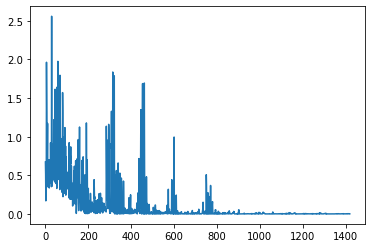

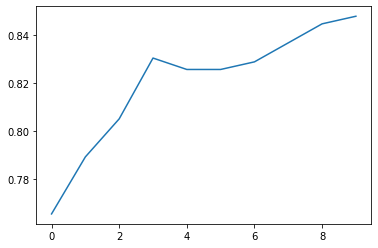

In [ ]:
epochs = 10
tot_losses = []
accuracies = []

for epoch in range(epochs):
  losses = train_model(model, train_iter, device)
  tot_losses.extend(losses)
  accuracy = evaluate_model(model, valid_iter, device)
  accuracies.append(accuracy)
  print(f"Valid accuracy: {accuracy}")

plt.figure()
plt.plot(tot_losses)
plt.figure()
plt.plot(accuracies)

Model accuracy on test set

In [ ]:
test_acc = evaluate_model(model, test_iter, device)
print(f"Test accuracy: {test_acc}")

Length of predictions: 631
Test accuracy: 0.8478605151176453


In [ ]:
print(len(train_iter))
print(len(valid_iter))
print(len(test_iter))

142
36
20


CNN

In [ ]:
class TextClassCNN(nn.Module):
  def __init__(self):
    super(TextClassCNN, self).__init__()
    self.embed = nn.Embedding(len(vocab), embedding_dim=100)
    self.embed.weight.data.copy_(vocab.vectors)
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels=100, out_channels=64, kernel_size=(3,1), padding=(1,0)),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,1), padding=(1,0)),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,1), padding=(1,0)),
        nn.ReLU()
    )
    self.fc = nn.Linear(in_features=16*200, out_features=2)
  def forward(self, input, lengths=None):
    embed = self.embed(input)

    if lengths is not None:
      lengths = lengths.view(-1).tolist()
      packed_emb = pack_padded_sequence(embed, lengths)

    embed = embed.reshape(-1, 100, 200, 1)

    seq = self.seq(embed)
    res = seq.reshape(-1, 16*200)

    fc = self.fc(res)
    out = fc

    return out

In [ ]:
data = next(iter(train_iter))
(x, x_len), y = data.titletext, data.label
print(x.shape)
print(x_len.shape)
print(y.shape)

torch.Size([32, 200])
torch.Size([32])
torch.Size([32])


In [ ]:
device = 'cpu'
cnn_model = TextClassCNN().to(device)
optimizer = torch.optim.Adam(cnn_model.parameters())
criterion = nn.CrossEntropyLoss()
print(cnn_model)

TextClassCNN(
  (embed): Embedding(20997, 100)
  (seq): Sequential(
    (0): Conv2d(100, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (5): ReLU()
  )
  (fc): Linear(in_features=3200, out_features=2, bias=True)
)


	Epoch 0 | Batch 0 | Loss   0.71
	Epoch 0 | Batch 50 | Loss   0.70
	Epoch 0 | Batch 100 | Loss   0.62
Epoch 0 | Loss   0.69
Length of predictions: 631
Validation accuracy: 0.49920761585235596
	Epoch 1 | Batch 0 | Loss   0.69
	Epoch 1 | Batch 50 | Loss   0.64
	Epoch 1 | Batch 100 | Loss   0.29
Epoch 1 | Loss   0.49
Length of predictions: 631
Validation accuracy: 0.838351845741272
	Epoch 2 | Batch 0 | Loss   0.77
	Epoch 2 | Batch 50 | Loss   0.26
	Epoch 2 | Batch 100 | Loss   0.20
Epoch 2 | Loss   0.22
Length of predictions: 631
Validation accuracy: 0.8858954310417175
	Epoch 3 | Batch 0 | Loss   0.25
	Epoch 3 | Batch 50 | Loss   0.01
	Epoch 3 | Batch 100 | Loss   0.09
Epoch 3 | Loss   0.08
Length of predictions: 631
Validation accuracy: 0.8843106031417847
	Epoch 4 | Batch 0 | Loss   0.14
	Epoch 4 | Batch 50 | Loss   0.01
	Epoch 4 | Batch 100 | Loss   0.00
Epoch 4 | Loss   0.03
Length of predictions: 631
Validation accuracy: 0.8700475692749023
	Epoch 5 | Batch 0 | Loss   0.09
	Epoch 5 | B

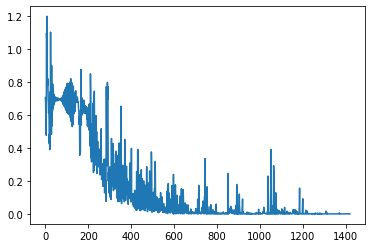

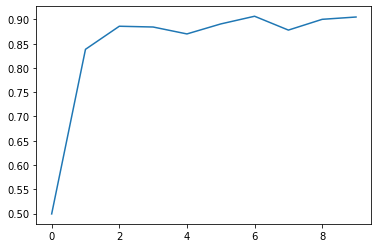

In [ ]:
epochs = 10
tot_losses = []
accuracies = []

for epoch in range(epochs):
  losses = train_model(cnn_model, train_iter, device)
  tot_losses.extend(losses)
  accuracy = evaluate_model(cnn_model, valid_iter, device)
  accuracies.append(accuracy)
  print(f"Validation accuracy: {accuracy}")

plt.figure()
plt.plot(tot_losses)
plt.figure()
plt.plot(accuracies)

Model accuracy on test set

In [ ]:
test_acc = evaluate_model(cnn_model, test_iter, device)
print(f"Test accuracy: {test_acc}")

Length of predictions: 631
Test accuracy: 0.9049128293991089


In [ ]:
evaluate_model(cnn_model, train_iter, device)

Length of predictions: 631


tensor(0.9049)

RNN

In [ ]:
input_size = 100
sequence_length = 200
hidden_size = 128
num_layers = 1
num_classes = 2

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.sequence_length = 200
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes
    self.samp_num = 0

    self.embed = nn.Embedding(len(vocab), embedding_dim=100)
    self.embed.weight.data.copy_(vocab.vectors)

    self.GRU = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first = True)  
    self.linear = nn.Linear(self.hidden_size, self.num_classes)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    embed = self.embed(x)
    embed = embed.reshape(-1, 200, 100)

    out, _ = self.GRU(embed, h0)
    # if self.samp_num % 1000 == 0:
    #   print(f"RNN output: {out.shape}")
    out = out[:, -1, :]
    # if self.samp_num % 1000 == 0:
    #   print(f"Reshaped RNN output: {out.shape}")

    # self.samp_num += 1

    out = self.linear(out)
    return out

In [ ]:
#  test = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#  x, y = next(train(iter))
#  x = x[1][0]
#  y = x
#
#  h0 = torch.zeros(num_layers, x.size(0), hidden_size)

In [ ]:
device = 'cpu'
rnn_model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

In [ ]:
print(rnn_model)

RNN(
  (embed): Embedding(20997, 100)
  (GRU): GRU(100, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)


	Epoch 0 | Batch 0 | Loss   0.72
	Epoch 0 | Batch 50 | Loss   0.62
	Epoch 0 | Batch 100 | Loss   0.52
Epoch 0 | Loss   0.67
Length of predictions: 631
Validation accuracy: 0.668779730796814
	Epoch 1 | Batch 0 | Loss   0.79
	Epoch 1 | Batch 50 | Loss   0.50
	Epoch 1 | Batch 100 | Loss   0.38
Epoch 1 | Loss   0.52
Length of predictions: 631
Validation accuracy: 0.7955626249313354
	Epoch 2 | Batch 0 | Loss   1.65
	Epoch 2 | Batch 50 | Loss   0.38
	Epoch 2 | Batch 100 | Loss   0.08
Epoch 2 | Loss   0.38
Length of predictions: 631
Validation accuracy: 0.825673520565033
	Epoch 3 | Batch 0 | Loss   0.66
	Epoch 3 | Batch 50 | Loss   0.20
	Epoch 3 | Batch 100 | Loss   0.04
Epoch 3 | Loss   0.25
Length of predictions: 631
Validation accuracy: 0.8605388402938843
	Epoch 4 | Batch 0 | Loss   2.56
	Epoch 4 | Batch 50 | Loss   0.09
	Epoch 4 | Batch 100 | Loss   0.00
Epoch 4 | Loss   0.22
Length of predictions: 631
Validation accuracy: 0.8605388402938843
	Epoch 5 | Batch 0 | Loss   0.67
	Epoch 5 | Bat

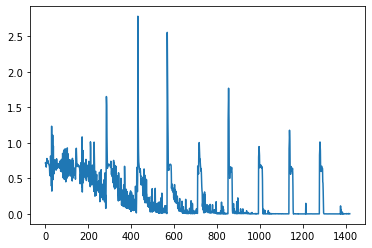

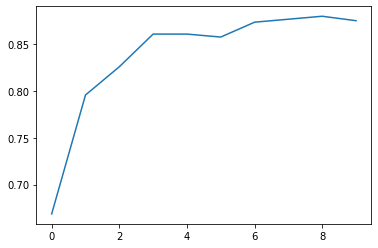

In [ ]:
epochs = 10
tot_losses = []
accuracies = []

for epoch in range(epochs):
  losses = train_model(rnn_model, train_iter, device)
  tot_losses.extend(losses)
  accuracy = evaluate_model(rnn_model, valid_iter, device)
  accuracies.append(accuracy)
  print(f"Validation accuracy: {accuracy}")

plt.figure()
plt.plot(tot_losses)
plt.figure()
plt.plot(accuracies)

Model accuracy on test set

In [ ]:
test_acc = evaluate_model(rnn_model, test_iter, device)
print(f"Test accuracy: {test_acc}")

Length of predictions: 631
Test accuracy: 0.8748018741607666
